[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/ersip-sprint/blob/master/sprints/1/5%20-%20Pattern%20Spectra.ipynb)

In [ ]:
# ! pip install sap
# ! wget https://github.com/kshitijrajsharma/ersip-sprint/raw/master/static/data.zip
# ! unzip data.zip
# ! rm data.zip

In [1]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import matplotlib as mpl
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees

/home/krschap/academia/ersip-sprint/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pattern Spectra (PS)

![](img/ps.svg)

## 0. Setup: Load the DSM tile and compute the max-tree

- Load the dsm tile `tile_path`.
- Compute the max-tree.

In [2]:
tile_path = Path('data/dsm_vox_50cm_tile_-12_0.tif')
dsm = rio.open(tile_path).read(1)
max_tree = sap.MaxTree(dsm)
print(f"DSM shape: {dsm.shape}")
print(f"Max-tree nodes: {max_tree.num_nodes()}")

DSM shape: (2001, 2001)
Max-tree nodes: 6119633


## 1. Compute attributes and visualize the distrbution of values

- Compute the `area` and `compactness` attributes
- How can we visualize the distribution of values? Display the distribution of areas, then compactness.
    + Tip: you can some matplotlib functions to plot the visualizations!

Area range: [1.00, 4004001.00]
Compactness range: [0.0020, 1.0000]


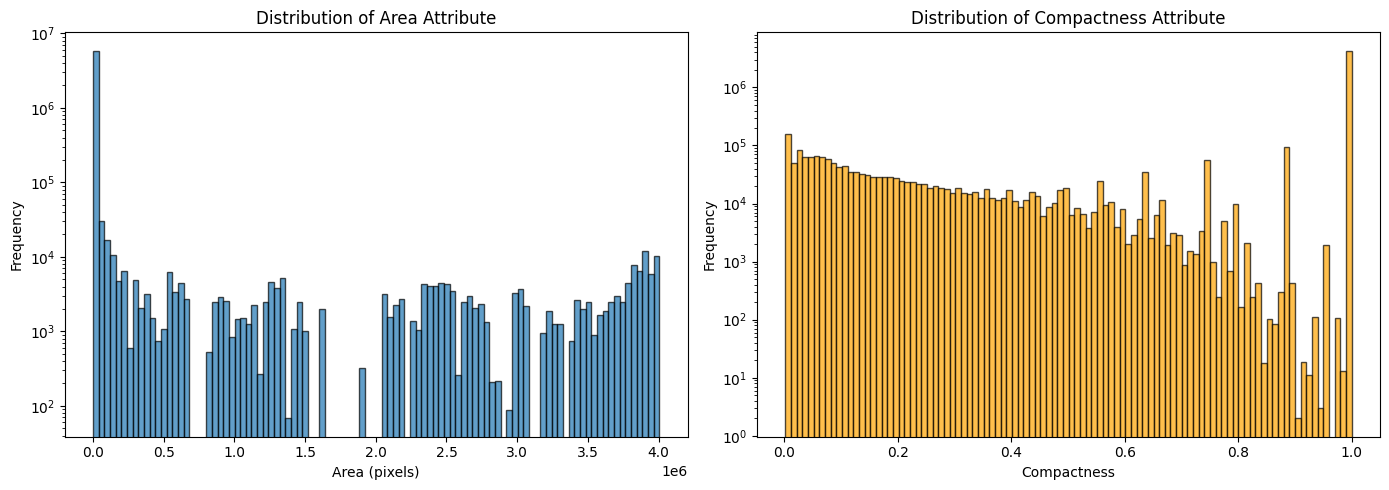

In [3]:
area = max_tree.get_attribute('area')
compactness = max_tree.get_attribute('compactness')

print(f"Area range: [{area.min():.2f}, {area.max():.2f}]")
print(f"Compactness range: [{compactness.min():.4f}, {compactness.max():.4f}]")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(area, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Area (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Area Attribute')
axes[0].set_yscale('log')

axes[1].hist(compactness, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Compactness')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Compactness Attribute')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()



# 2. Compute a Pattern Spectrum

The pattern spectrum can be seen as nodes attributes probability distribution: for a given attribute value we display the probability to have nodes with these properties in the image.

To compute the Pattern Spectrum, you need to weight the histograms with the area of the flat zone times the height diffence of the flat zone and its direct ancester.

- Compute and display the Pattern Spectrum
    - For `area` attributes
    - For `compactness` attributes

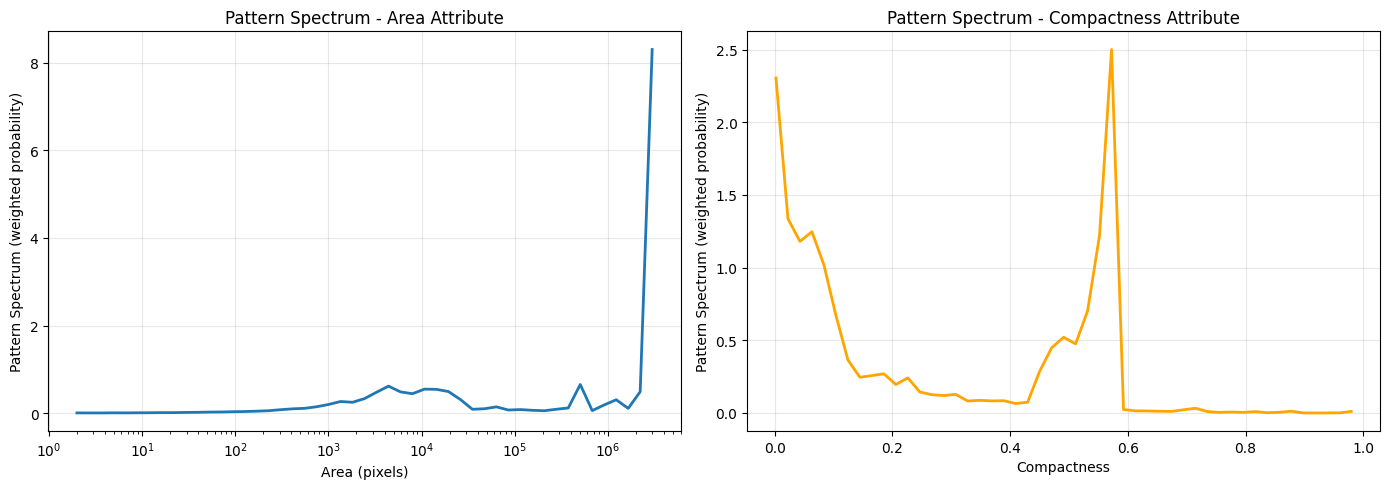

In [4]:
dh = max_tree._alt - max_tree._alt[max_tree._tree.parents()]
weights = area * dh

area_bins = np.logspace(np.log10(area.min() + 1), np.log10(area.max()), 50)
compactness_bins = np.linspace(compactness.min(), compactness.max(), 50)

area_ps, _ = np.histogram(area, bins=area_bins, weights=weights)
area_ps = area_ps / dsm.size

compactness_ps, _ = np.histogram(compactness, bins=compactness_bins, weights=weights)
compactness_ps = compactness_ps / dsm.size

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(area_bins[:-1], area_ps, linewidth=2)
axes[0].set_xlabel('Area (pixels)')
axes[0].set_ylabel('Pattern Spectrum (weighted probability)')
axes[0].set_title('Pattern Spectrum - Area Attribute')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].plot(compactness_bins[:-1], compactness_ps, linewidth=2, color='orange')
axes[1].set_xlabel('Compactness')
axes[1].set_ylabel('Pattern Spectrum (weighted probability)')
axes[1].set_title('Pattern Spectrum - Compactness Attribute')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Compute and display a 2D Pattern Spectrum with SAP

- Compute a 2D PS with SAP
- Find objet of interrest in the spectrum
- Filter the DSM according to the object of interest in the spectum

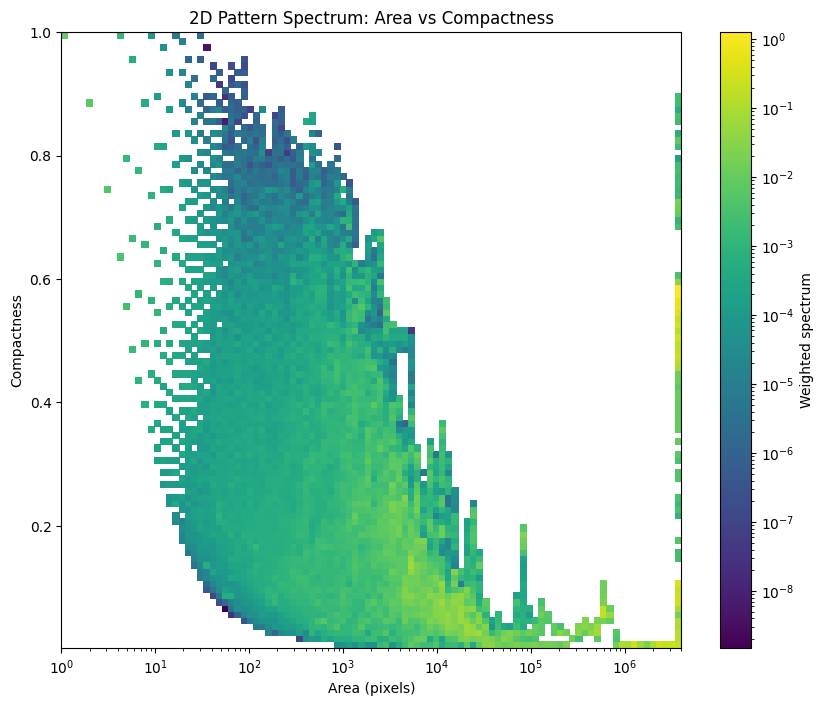

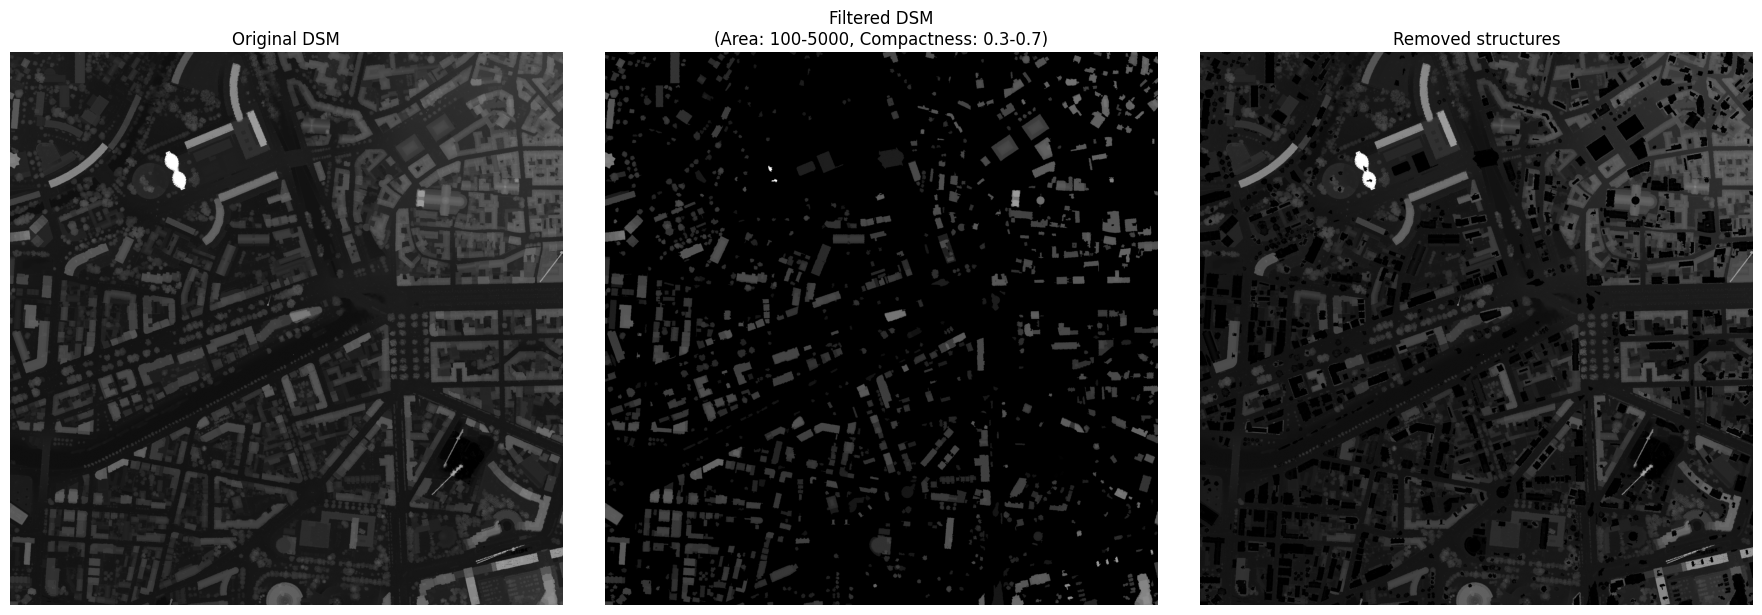

Objects of interest selected based on 2D pattern spectrum:
  Area range: [100, 5000]
  Compactness range: [0.3, 0.7]
  Nodes matching criteria: 144836 out of 6119633


In [6]:
s, xedges, yedges, x_log, y_log = sap.spectrum2d(max_tree, 'area', 'compactness', 
                                                       x_count=100, y_count=100, 
                                                       x_log=True, y_log=False)

plt.figure(figsize=(10, 8))
sap.show_spectrum(s, xedges, yedges, x_log, y_log, log_scale=True)
plt.colorbar(label='Weighted spectrum')
plt.xlabel('Area (pixels)')
plt.ylabel('Compactness')
plt.title('2D Pattern Spectrum: Area vs Compactness')
plt.show()

area_threshold_min = 100
area_threshold_max = 5000
compactness_threshold_min = 0.3
compactness_threshold_max = 0.7

node_mask = (area >= area_threshold_min) & (area <= area_threshold_max) & \
            (compactness >= compactness_threshold_min) & (compactness <= compactness_threshold_max)

deleted_nodes = ~node_mask
filtered_dsm = max_tree.reconstruct(deleted_nodes)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(dsm, cmap='gray')
axes[0].set_title('Original DSM')
axes[0].axis('off')

axes[1].imshow(filtered_dsm, cmap='gray')
axes[1].set_title(f'Filtered DSM\n(Area: {area_threshold_min}-{area_threshold_max}, Compactness: {compactness_threshold_min}-{compactness_threshold_max})')
axes[1].axis('off')

axes[2].imshow(dsm - filtered_dsm, cmap='gray')
axes[2].set_title('Removed structures')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Objects of interest selected based on 2D pattern spectrum:")
print(f"  Area range: [{area_threshold_min}, {area_threshold_max}]")
print(f"  Compactness range: [{compactness_threshold_min}, {compactness_threshold_max}]")
print(f"  Nodes matching criteria: {node_mask.sum()} out of {len(node_mask)}")

